In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn as sk
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


In [187]:
url = (
    "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?"
    "table=cumulative&format=csv"
)

# Directly load into DataFrame
df = pd.read_csv(url)

print(df.head())

      kepid kepoi_name   kepler_name koi_disposition koi_pdisposition  \
0  10797460  K00752.01  Kepler-227 b       CONFIRMED        CANDIDATE   
1  10797460  K00752.02  Kepler-227 c       CONFIRMED        CANDIDATE   
2  10811496  K00753.01           NaN       CANDIDATE        CANDIDATE   
3  10848459  K00754.01           NaN  FALSE POSITIVE   FALSE POSITIVE   
4  10854555  K00755.01  Kepler-664 b       CONFIRMED        CANDIDATE   

   koi_score  koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  koi_fpflag_ec  ...  \
0      1.000              0              0              0              0  ...   
1      0.969              0              0              0              0  ...   
2      0.000              0              0              0              0  ...   
3      0.000              0              1              0              0  ...   
4      1.000              0              0              0              0  ...   

   koi_slogg  koi_slogg_err1  koi_slogg_err2  koi_srad  koi_srad_err1  \
0

In [188]:
print(df.shape)

(9564, 50)


In [189]:
df.drop({'koi_fpflag_co', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_ec', 'koi_kepmag_err','kepid', 'kepoi_name', 'koi_tce_delivname', 'koi_score', 'kepler_name', 'koi_pdisposition', 'koi_teq_err2', 'koi_teq_err1'}, axis=1, inplace=True)

In [190]:
# Map to three categories
df['koi_disposition_class'] = df['koi_disposition'].apply(
    lambda x: 'CONFIRMED' if x == 'CONFIRMED' 
              else ('CANDIDATE' if x == 'CANDIDATE' else 'OTHER')
)

# Encode into numbers
class_map = {'CONFIRMED': 2, 'CANDIDATE': 1, 'OTHER': 0}
df['koi_disposition_encoded'] = df['koi_disposition_class'].map(class_map)

print(df[['koi_disposition', 'koi_disposition_class', 'koi_disposition_encoded']].head())


  koi_disposition koi_disposition_class  koi_disposition_encoded
0       CONFIRMED             CONFIRMED                        2
1       CONFIRMED             CONFIRMED                        2
2       CANDIDATE             CANDIDATE                        1
3  FALSE POSITIVE                 OTHER                        0
4       CONFIRMED             CONFIRMED                        2


In [191]:
df = df.select_dtypes(exclude=['object'])

In [192]:
df = df.fillna(value=np.nan)
print(df.shape)
df = df.dropna()
print(df.shape)

(9564, 35)
(8744, 35)


In [193]:
print(df.shape)
corr_matrix = df.corr().abs()

# Select upper triangle
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Drop columns with correlation > 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
df = df.drop(columns=to_drop)

print(df.shape)


(8744, 35)
(8744, 29)


In [194]:


print(df.shape)

vif = pd.DataFrame()
vif["feature"] = df.columns
vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

high_vif_cols = vif[vif['VIF'] > 10]['feature'].tolist()
high_vif_cols = [col for col in high_vif_cols if col != 'const']
df = df.drop(columns=high_vif_cols)

print(vif)



vif = pd.DataFrame()
vif["feature"] = df.columns
vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
print(vif)
print(df.shape)

(8744, 29)
                    feature         VIF
0                koi_period    3.753605
1           koi_period_err1    2.446443
2               koi_time0bk   12.799302
3          koi_time0bk_err1    1.804326
4                koi_impact    5.138475
5           koi_impact_err1    1.168577
6           koi_impact_err2    3.213154
7              koi_duration    2.370074
8         koi_duration_err1    2.259082
9                 koi_depth    1.909716
10           koi_depth_err1    1.099408
11                 koi_prad    2.438893
12            koi_prad_err1    3.089294
13                  koi_teq    7.475967
14                koi_insol    9.521061
15           koi_insol_err1    9.135811
16            koi_model_snr    1.894081
17         koi_tce_plnt_num    4.979109
18                koi_steff   86.917647
19           koi_steff_err1   41.320709
20           koi_steff_err2   24.521400
21                koi_slogg  211.373020
22           koi_slogg_err1    2.704370
23           koi_slogg_err2  

In [ ]:
# Multinomial logistic regression

X_train, X_test, y_train, y_test = train_test_split(df.drop("koi_disposition_encoded", axis = 1), df["koi_disposition_encoded"] , test_size = 0.2)
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)

X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns, index=X_test.index)


clf = LogisticRegression(
    max_iter=1000,
    multi_class='multinomial',
    solver='lbfgs'
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", sk.metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.6483704974271012


c:\Users\santi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [196]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [197]:
xgb_model = XGBClassifier(
    objective='multi:softmax',
    random_state=42) 


In [198]:
# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

In [199]:
print("Accuracy:", sk.metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6723842195540308


In [200]:
cm = confusion_matrix(y_test, y_pred)

print(cm)

[[769  99   9]
 [167 165  15]
 [150 133 242]]


In [201]:
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

In [202]:
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',   # Use accuracy as the evaluation metric
    cv=3,                 # 3-fold cross-validation
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 0.8, 1.0]},
             scoring='accuracy', verbose=2)

In [203]:
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: ", grid_search.best_score_)

# Predict on test set
y_pred = grid_search.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred, target_names=['OTHER','CANDIDATE','CONFIRMED']))

Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.7}
Best cross-validation accuracy:  0.8024304628078213
              precision    recall  f1-score   support

       OTHER       0.73      0.90      0.81       877
   CANDIDATE       0.44      0.43      0.43       347
   CONFIRMED       0.91      0.56      0.69       525

    accuracy                           0.71      1749
   macro avg       0.69      0.63      0.64      1749
weighted avg       0.72      0.71      0.70      1749



           OTHER  CANDIDATE  CONFIRMED
OTHER        793         74         10
CANDIDATE    179        148         20
CONFIRMED    119        112        294


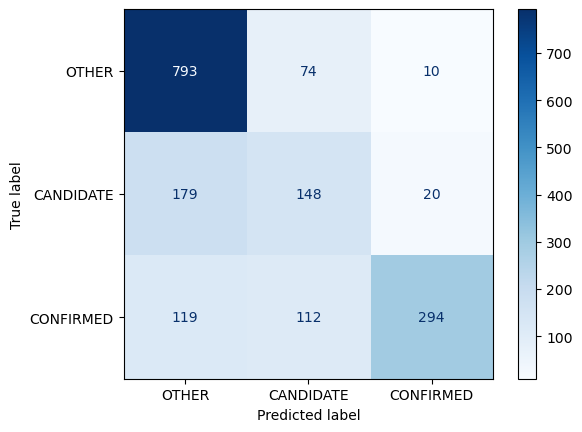

In [204]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['OTHER','CANDIDATE','CONFIRMED'], columns=['OTHER','CANDIDATE','CONFIRMED'])
print(cm_df)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['OTHER','CANDIDATE','CONFIRMED'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [205]:
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)

print(feature_importances)

              feature  importance
10           koi_prad    0.147967
7   koi_duration_err1    0.125446
14     koi_insol_err1    0.101017
15      koi_model_snr    0.095719
11      koi_prad_err1    0.060007
0          koi_period    0.055681
16   koi_tce_plnt_num    0.052188
6        koi_duration    0.030913
3          koi_impact    0.029870
19           koi_srad    0.029019
18     koi_slogg_err2    0.028109
1     koi_period_err1    0.026540
8           koi_depth    0.026111
20      koi_srad_err1    0.024908
2    koi_time0bk_err1    0.023027
9      koi_depth_err1    0.022997
5     koi_impact_err2    0.022388
12            koi_teq    0.022088
21      koi_srad_err2    0.021022
4     koi_impact_err1    0.019796
17     koi_slogg_err1    0.019605
13          koi_insol    0.015582


<Figure size 1000x800 with 0 Axes>

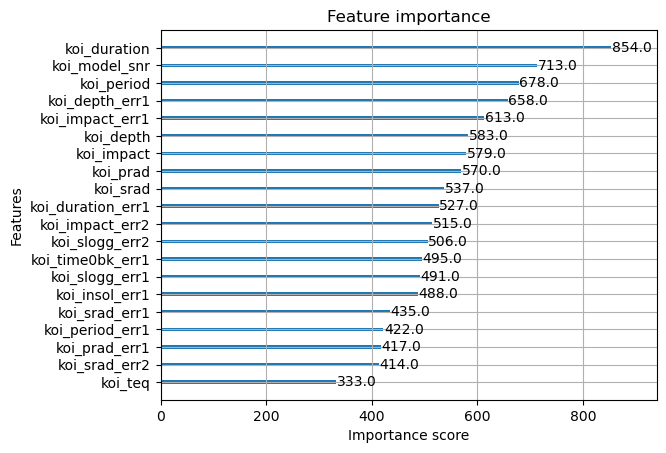

In [206]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(10,8))
plot_importance(xgb_model, max_num_features=20, importance_type='weight')  # or 'gain', 'cover'
plt.show()


In [207]:
top_features = feature_importances.head(10)['feature'].tolist()
print("Top 10 features:", top_features)

Top 10 features: ['koi_prad', 'koi_duration_err1', 'koi_insol_err1', 'koi_model_snr', 'koi_prad_err1', 'koi_period', 'koi_tce_plnt_num', 'koi_duration', 'koi_impact', 'koi_srad']


In [208]:
X_train = X_train[top_features]
X_test = X_test[top_features]


In [209]:
grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: ", grid_search.best_score_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


c:\Users\santi\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
Best cross-validation accuracy:  0.7971406839331369


In [210]:
# Evaluate
print(classification_report(y_test, y_pred, target_names=['OTHER','CANDIDATE','CONFIRMED']))

              precision    recall  f1-score   support

       OTHER       0.73      0.90      0.81       877
   CANDIDATE       0.44      0.43      0.43       347
   CONFIRMED       0.91      0.56      0.69       525

    accuracy                           0.71      1749
   macro avg       0.69      0.63      0.64      1749
weighted avg       0.72      0.71      0.70      1749



           OTHER  CANDIDATE  CONFIRMED
OTHER        793         74         10
CANDIDATE    179        148         20
CONFIRMED    119        112        294


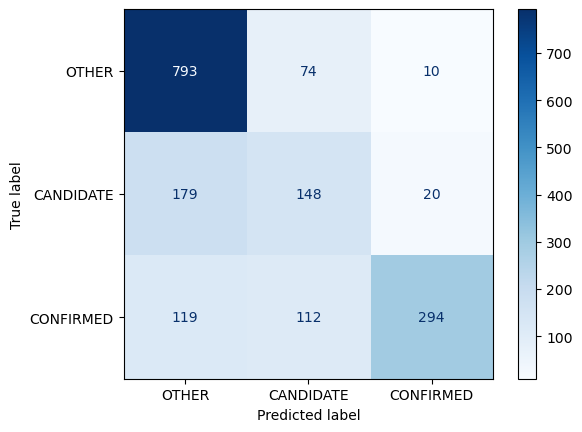

In [211]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['OTHER','CANDIDATE','CONFIRMED'], columns=['OTHER','CANDIDATE','CONFIRMED'])
print(cm_df)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['OTHER','CANDIDATE','CONFIRMED'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [212]:
import numpy as np
y_pred_proba = grid_search.predict_proba(X_test)
def classify_with_thresholds(proba, threshold_confirmed=0.7, threshold_other=0.6):
    """
    Custom classification with adjustable thresholds
    """
    predictions = []
    
    for prob in proba:
        p_other, p_candidate, p_confirmed = prob
        
        # High confidence for CONFIRMED
        if p_confirmed >= threshold_confirmed:
            predictions.append('CONFIRMED')
        # High confidence for OTHER (false positive)
        elif p_other >= threshold_other:
            predictions.append('OTHER')
        # Everything else is CANDIDATE
        else:
            predictions.append('CANDIDATE')
    
    return np.array(predictions)

# Apply custom thresholds
y_pred_custom = classify_with_thresholds(y_pred_proba, 
                                         threshold_confirmed=0.75, 
                                         threshold_other=0.70)

In [213]:
from sklearn.metrics import classification_report
import pandas as pd

def grid_search_thresholds(y_true, y_pred_proba, metric='accuracy'):
    """
    Find optimal thresholds by grid search
    """
    results = []
    
    # Try different threshold combinations
    for thresh_confirmed in np.arange(0.5, 0.95, 0.05):
        for thresh_other in np.arange(0.5, 0.95, 0.05):
            
            y_pred = classify_with_thresholds(y_pred_proba, 
                                             thresh_confirmed, 
                                             thresh_other)
            
            # Calculate metrics
            accuracy = accuracy_score(y_true, y_pred)
            
            results.append({
                'thresh_confirmed': thresh_confirmed,
                'thresh_other': thresh_other,
                'acc_weighted': accuracy
            })
    
    results_df = pd.DataFrame(results)
    best = results_df.loc[results_df['acc_weighted'].idxmax()]
    
    return results_df, best

# Find optimal thresholds
results_df, best_thresholds = grid_search_thresholds(y_test, y_pred_proba)
print(f"Best thresholds: {best_thresholds}")

Best thresholds: thresh_confirmed    0.5
thresh_other        0.5
acc_weighted        0.0
Name: 0, dtype: float64
